In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy
import pandas as pd

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


## SIR Model

$$
\frac{dS}{dt} = −βSI
$$
$$
\frac{dI}{dt} = βSI − γI
$$
$$
\frac{dR}{dt} = γI.
$$


In [2]:

df = pd.read_csv("../data/covid-es-2021.csv", encoding="latin-1", sep=",")

df = df[df["Evolucao"].isin(["Cura", "Óbito pelo COVID-19"])]

df["NotificationDate"] = df["DataNotificacao"]
df["DeathDate"] = df["DataObito"]
df["RecoveryDate"] = df.apply(lambda row: row["DataEncerramento"] if row["Evolucao"] == "Cura" else None, axis=1)

df["NotificationDate"] = pd.to_datetime(df["NotificationDate"], format='%Y-%m-%d')
df["DeathDate"] = pd.to_datetime(df["DeathDate"], format='%Y-%m-%d')
df["RecoveryDate"] = pd.to_datetime(df["RecoveryDate"], format='%Y-%m-%d')


df = df[df["RecoveryDate"] >= df["NotificationDate"]]


In [3]:

date_range = pd.date_range(
    start=df['NotificationDate'].min(),
    end=max(df['RecoveryDate'].max(), df['DeathDate'].max()),
    freq='D'
)

# Initialize SIR DataFrame
sir = pd.DataFrame(index=date_range, columns=['S', 'I', 'R'])

pd.set_option('future.no_silent_downcasting', True)
sir = sir.fillna(0)

# Track daily active and removed cases
for i, row in df.iterrows():
    
    # Active from notification until recovery/death
    start = row['NotificationDate']
    end = row['RecoveryDate'] if pd.notna(row['RecoveryDate']) else row['DeathDate']
    
    if pd.isna(end):  # Case is still active (no recovery/death)
        sir.loc[start:, 'I'] += 1
    else:  # Case becomes removed on recovery/death date
        assert start <= end, f"Inconsistency at row {i}, start={start}, end={end}, death={row["DeathDate"]}, rec={row["RecoveryDate"]}"
        sir.loc[start:end - pd.Timedelta(days=1), 'I'] += 1
        sir.loc[end:, 'R'] += 1

TOTAL_POPULATION = 342800  # 2023 Census
sir['S'] = TOTAL_POPULATION - sir['I'] - sir['R']


In [4]:
sir.head()

,S,I,R
2021-01-01,342113,685,2
2021-01-02,341179,1617,4
2021-01-03,340323,2461,16
2021-01-04,337533,5162,105
2021-01-05,335257,7287,256


In [5]:
# Parameters
t0, tf = 0, sir.shape[0]

S0 = sir.iloc[0, sir.columns.get_loc("S")]
I0 = sir.iloc[0, sir.columns.get_loc("I")]
R0 = sir.iloc[0, sir.columns.get_loc("R")]

In [6]:
# Leranable external parameters
beta = dde.Variable(0.5)
gamma = dde.Variable(0.5)

In [18]:
# Solving the model

def sir_model(t, y):

    S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    
    return [
        dS_dt - (-beta * S * I),
        dI_dt - (beta * S * I - gamma * I),
        dR_dt - (gamma * I)   
    ]


S_data = sir["S"].astype(float).values / TOTAL_POPULATION
I_data = sir["I"].astype(float).values / TOTAL_POPULATION
R_data = sir["R"].astype(float).values / TOTAL_POPULATION
t_data = np.arange(t0, tf).reshape(-1, 1)

observed_data = np.hstack([t_data, S_data.reshape(-1, 1), I_data.reshape(-1, 1), R_data.reshape(-1, 1)])


geom = dde.geometry.TimeDomain(t0, tf)

observe_t = t_data
observe_y = np.hstack([S_data.reshape(-1, 1), I_data.reshape(-1, 1), R_data.reshape(-1, 1)], dtype="float64")

print(observe_y.dtype)

bc_S = dde.icbc.PointSetBC(observe_t, observe_y[:, 0:1], component=0)  # S
bc_I = dde.icbc.PointSetBC(observe_t, observe_y[:, 1:2], component=1)  # I
bc_R = dde.icbc.PointSetBC(observe_t, observe_y[:, 2:3], component=2)  # R

"""
ic_S = dde.icbc.IC(geom, lambda _: S0, lambda _, on_initial: on_initial, component=0)
ic_I = dde.icbc.IC(geom, lambda _: I0, lambda _, on_initial: on_initial, component=1)
ic_R = dde.icbc.IC(geom, lambda _: R0, lambda _, on_initial: on_initial, component=2)
"""

data = dde.data.PDE(
    geom, 
    sir_model, 
    [bc_S, bc_I, bc_R],
    num_domain=100, 
    num_boundary=2,
    anchors=observe_t)

net = dde.nn.FNN([1] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001,  external_trainable_variables=[beta, gamma])

variable_cb = dde.callbacks.VariableValue([beta, gamma], period=1000, filename="variables.dat")


float64
Compiling model...
'compile' took 1.048927 s



Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.76e-03, 1.99e-02, 8.33e-03, 2.10e+00, 3.33e-02, 3.38e-01]    [2.76e-03, 1.99e-02, 8.33e-03, 2.10e+00, 3.33e-02, 3.38e-01]    []  
1000      [4.87e-06, 3.37e-07, 4.03e-06, 1.79e-06, 4.10e-06, 7.82e-07]    [4.87e-06, 3.37e-07, 4.03e-06, 1.79e-06, 4.10e-06, 7.82e-07]    []  
2000      [3.46e-06, 1.72e-07, 3.97e-06, 8.01e-07, 3.18e-06, 5.21e-07]    [3.46e-06, 1.72e-07, 3.97e-06, 8.01e-07, 3.18e-06, 5.21e-07]    []  
3000      [2.44e-05, 5.76e-07, 3.16e-05, 9.62e-05, 2.15e-04, 3.40e-04]    [2.44e-05, 5.76e-07, 3.16e-05, 9.62e-05, 2.15e-04, 3.40e-04]    []  
4000      [7.38e-06, 2.65e-07, 9.33e-06, 8.97e-06, 3.91e-05, 2.33e-04]    [7.38e-06, 2.65e-07, 9.33e-06, 8.97e-06, 3.91e-05, 2.33e-04]    []  
5000      [9.74e-07, 1.34e-07, 1.15e-06, 2.80e-07, 7.21e-07, 2.38e-07]    [9.74e-07, 1.34e-07, 1.15e-06, 2.80e-07, 7

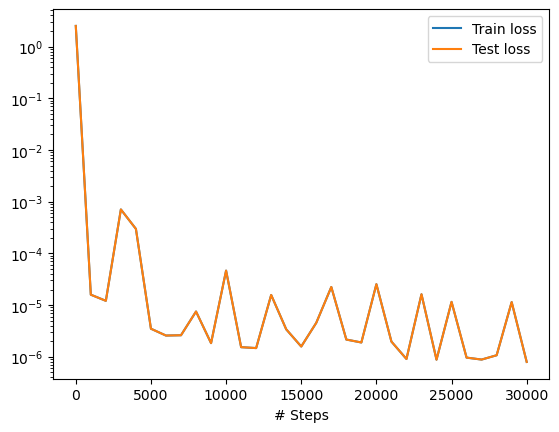

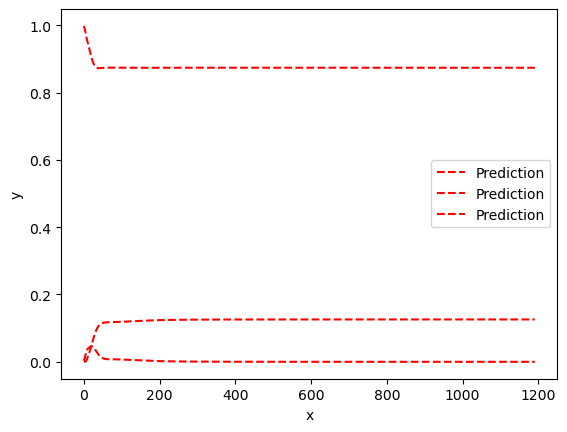

In [19]:

losshistory, train_state = model.train(iterations=30000, callbacks=[variable_cb], model_save_path="../models/reverse-sir")

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [21]:
beta_pred = beta.detach().cpu().numpy()
gamma_pred = gamma.detach().cpu().numpy()

print(f"Learned parameters: beta = {beta_pred:.4f}, gamma = {gamma_pred:.4f}")


Learned parameters: beta = 0.0841, gamma = 0.0761


In [14]:

model.restore("../models/reverse-sir-30000.pt")

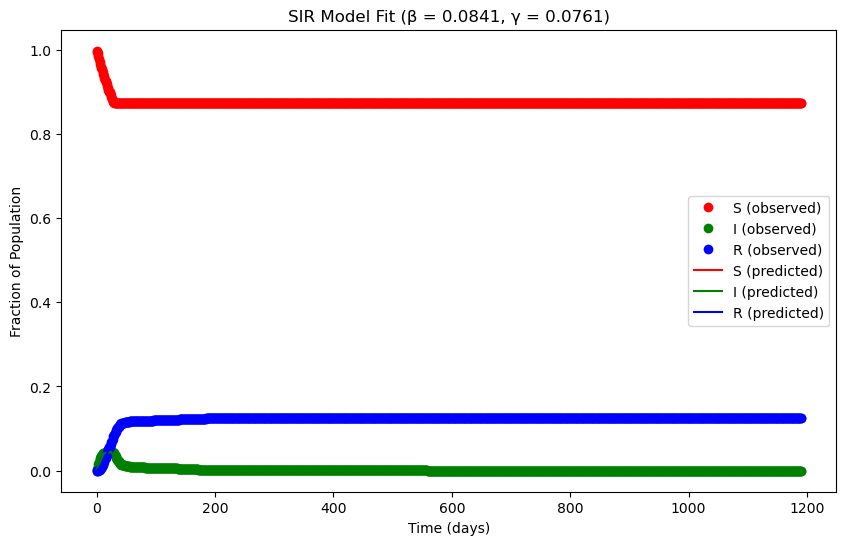

In [22]:

def sir_ode(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

nop = 100

t_test = np.linspace(t_data.min(), t_data.max(), nop).reshape(-1, 1)
y_pred = model.predict(t_test)
S_pred, I_pred, R_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

plt.figure(figsize=(10, 6))
plt.plot(t_data, S_data, "ro", label="S (observed)")
plt.plot(t_data, I_data, "go", label="I (observed)")
plt.plot(t_data, R_data, "bo", label="R (observed)")
plt.plot(t_test, S_pred, "r-", label="S (predicted)")
plt.plot(t_test, I_pred, "g-", label="I (predicted)")
plt.plot(t_test, R_pred, "b-", label="R (predicted)")
plt.xlabel("Time (days)")
plt.ylabel("Fraction of Population")
plt.legend()
plt.title(f"SIR Model Fit (β = {beta_pred:.4f}, γ = {gamma_pred:.4f})")
plt.savefig("../figures/reverse-sir")
plt.show()